# Clustering of Crimes Locations 

Using as input data the crime of Chicago dataset, develop a Jupyter notebook that perform a clustering of the locations (latitude, longitude)  after asking for the number of clusters and to select at least two of the clustering algorithms in SparkML.

The results plot shoud include in a 2D chart the centroids and the points of each cluster. Optionally, these information can be plotted on top of a map of Chicago.


# 0. Importing the librarys.

In [160]:
import sys
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.sql.types import *

from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
%matplotlib inline

# 1. Loading, preparing and cleaning the data.

In [2]:
# We create a SparkSession instance 
spark_session = SparkSession \
        .builder \
        .getOrCreate()

In [3]:
# Now, We create the structure type of the dataframe of crimes of Chicago.
schema = StructType([StructField('ID', StringType(),False), \
                            StructField('Case_Number', StringType(), False), \
                            StructField('Date', StringType(), False), \
                            StructField('Block', StringType(), False), \
                            StructField('IUCR', StringType(), False), \
                            StructField('Primary_Type', StringType(), False), \
                            StructField('Description', StringType(), False), \
                            StructField('Location_Description', StringType(), False), \
                            StructField('Arrest', StringType(), False), \
                            StructField('Domestic', StringType(), False), \
                            StructField('Beat', StringType(), False), \
                            StructField('District', StringType(), False), \
                            StructField('Ward', StringType(), False), \
                            StructField('Community_Area', StringType(), False), \
                            StructField('FBI_Code', StringType(), False), \
                            StructField('X_Coordinate', StringType(), False), \
                            StructField('Y_Coordinate', StringType(), False), \
                            StructField('Year', StringType(), False), \
                            StructField('Update_On', StringType(), False), \
                            StructField('Latitude', StringType(), False), \
                            StructField('Longitude', StringType(), False), \
                            StructField('Location', StringType(), False)])

In [4]:
# Load dataframe Chicago Crimes.
data_frame = spark_session\
        .read\
        .format("csv") \
        .schema(schema) \
        .load("C:\datosmlib\MLlib\Task1_advanced\Crimes_-_2001_to_present.csv")

# Print Schema.
data_frame.printSchema()


root
 |-- ID: string (nullable = true)
 |-- Case_Number: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary_Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location_Description: string (nullable = true)
 |-- Arrest: string (nullable = true)
 |-- Domestic: string (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- Community_Area: string (nullable = true)
 |-- FBI_Code: string (nullable = true)
 |-- X_Coordinate: string (nullable = true)
 |-- Y_Coordinate: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Update_On: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Location: string (nullable = true)



In [5]:
data_frame.show(n=5,truncate=False)

+--------+-----------+----------------------+----------------------+----+-------------+-----------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------------------+------------+-------------+-----------------------------+
|ID      |Case_Number|Date                  |Block                 |IUCR|Primary_Type |Description            |Location_Description|Arrest|Domestic|Beat|District|Ward|Community_Area|FBI_Code|X_Coordinate|Y_Coordinate|Year|Update_On             |Latitude    |Longitude    |Location                     |
+--------+-----------+----------------------+----------------------+----+-------------+-----------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------------------+------------+-------------+-----------------------------+
|ID      |Case Number|Date                  |Block                 |IUCR|Primary Type |Desc

In [6]:
# We have a lot of rows.
data_frame.count()

6550219

In [7]:
# Here. We are going to modify String types columns to numbers types columns, and we eliminate null rows.
Casting_data_frame = data_frame.select('ID','Primary_Type', 'Location_Description', data_frame.District.cast('integer'), \
                                       data_frame.Latitude.cast('double'), data_frame.Longitude.cast('double')).na.drop()

Casting_data_frame.show(n=5,truncate=False)

+--------+-------------+--------------------+--------+------------+-------------+
|ID      |Primary_Type |Location_Description|District|Latitude    |Longitude    |
+--------+-------------+--------------------+--------+------------+-------------+
|10000092|BATTERY      |STREET              |11      |41.891398861|-87.744384567|
|10000094|OTHER OFFENSE|STREET              |7       |41.773371528|-87.665319468|
|10000095|BATTERY      |APARTMENT           |2       |41.81386068 |-87.596642837|
|10000096|BATTERY      |APARTMENT           |2       |41.800802415|-87.622619343|
|10000097|ROBBERY      |SIDEWALK            |11      |41.878064761|-87.743354013|
+--------+-------------+--------------------+--------+------------+-------------+
only showing top 5 rows



In [9]:
# We create a dataframe with label and features columns.
data_frame_clustering = data_frame_casting \
        .rdd \
        .map(lambda x: (x[0],Vectors.dense(x[1:3]))).toDF(["ID", "features"])

data_frame_clustering.show(5)

+--------+--------------------+
|      ID|            features|
+--------+--------------------+
|10000092|[41.891398861,-87...|
|10000094|[41.773371528,-87...|
|10000095|[41.81386068,-87....|
|10000096|[41.800802415,-87...|
|10000097|[41.878064761,-87...|
+--------+--------------------+
only showing top 5 rows



In [151]:
# This is another way to do the dataframe above but with dataframe class only, without RDD.
vecAssembler = VectorAssembler(inputCols=["Latitude", "Longitude"], outputCol="features")
data_frame_clustering_df = vecAssembler.transform(data_frame_casting).select('ID','features')

data_frame_clustering_df.show(5)

+--------+--------------------+
|      ID|            features|
+--------+--------------------+
|10000092|[41.891398861,-87...|
|10000094|[41.773371528,-87...|
|10000095|[41.81386068,-87....|
|10000096|[41.800802415,-87...|
|10000097|[41.878064761,-87...|
+--------+--------------------+
only showing top 5 rows



## 2. implementing Clustering algorithm 

#### 2.1 Elbow Curve.

K-means is a simple unsupervised machine learning algorithm that groups a dataset into a user-specified number (k) of clusters. The algorithm is somewhat naive--it clusters the data into k clusters, even if k is not the right number of clusters to use. Therefore, when using k-means clustering, users need some way to determine whether they are using the right number of clusters.

One method to validate the number of clusters is the elbow method. The idea of the elbow method is to run k-means clustering on the dataset for a range of values of k (say, k from 1 to 10 in the examples below), and for each value of k calculate the sum of squared errors (SSE). Then, plot a line chart of the SSE for each value of k. If the line chart looks like an arm, then the "elbow" on the arm is the value of k that is the best. The idea is that we want a small SSE, but that the SSE tends to decrease toward 0 as we increase k (the SSE is 0 when k is equal to the number of data points in the dataset, because then each data point is its own cluster, and there is no error between it and the center of its cluster). So our goal is to choose a small value of k that still has a low SSE, and the elbow usually represents where we start to have diminishing returns by increasing k.

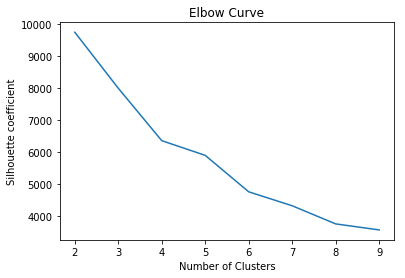

In [319]:
# Prepare training and test data.
train, test = data_frame_clustering.randomSplit([0.7, 0.3], seed=42)
kn = range(2,10)
cost_seek=[]
predictions_seek=[]

for i in kn:

    # Trains a k-means model.
    kmeans_seek = KMeans().setK(i).setSeed(42)
    model_seek = kmeans_seek.fit(train)

    # Make predictions
    predictions = (model_seek.transform(test))
    predictions_seek.append(predictions)
    
    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()
     
    cost = model_seek.computeCost(test)
    cost_seek.append(cost)
    
# Plot the results     
plt.plot(kn,silhouette_seek)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette coefficient')
plt.title('Elbow Curve')
plt.show()

#### 2.2 K-Means algorithm applying TrainValidationSplit tools.

In [12]:
# Prepare training and test data.
train, test = data_frame_clustering.randomSplit([0.7, 0.3], seed=42)

# We instance KMeans class.
kmeans = KMeans()

# We use a ParamGridBuilder to consmtruct a grid of parameters to search over.
# TrainValidationSplit will try all combinations of values and determine best model using
# the evaluator.
paramGrid = ParamGridBuilder()\
    .addGrid(kmeans.setK, [2,3,4,5,6,7,8,9,10]) \
    .addGrid(kmeans.setSeed, [42])\
    .build()
    
# Now, we set TrainValidationSplit, that requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
kmeans_train_validation = TrainValidationSplit(estimator=kmeans,
                               estimatorParamMaps=paramGrid,
                               evaluator= ClusteringEvaluator(),
                               trainRatio=0.8) # 80% of the data will be used for training, 20% for validation.

# We train the model.
model = kmeans_train_validation.fit(train)

# Make predictions
predictions = model.bestModel.transform(test)
predictions.show(10)

# Evaluate clustering by computing Silhouette score
silhouette = evaluator.evaluate(predictions)
print("The Best Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.bestModel.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

+----+--------------------+----------+
|  ID|            features|prediction|
+----+--------------------+----------+
|4757|[41.850436084,-87...|         0|
|4758|[41.815555438,-87...|         1|
|4759|[41.776221083,-87...|         1|
|4769|[41.809519024,-87...|         1|
|4772|[41.776816906,-87...|         1|
|4782|[41.765693367,-87...|         1|
|4784|[41.771874483,-87...|         1|
|4785|[41.758275857,-87...|         1|
|4790|[41.863318307,-87...|         0|
|4791|[41.850350125,-87...|         0|
+----+--------------------+----------+
only showing top 10 rows

The Best Silhouette with squared euclidean distance = 0.7011976508763009
Cluster Centers: 
[ 41.91172541 -87.7035692 ]
[ 41.76178418 -87.63537083]


#### 2.3 K-Means algorithm applying CrossValidation tools.

In [14]:
# Prepare training and test data.
train, test = data_frame_clustering.randomSplit([0.7, 0.3], seed=42)

# We instance KMeans class.
kmeans = KMeans()

# We use a ParamGridBuilder to construct a grid of parameters to search over.
# TrainValidationSplit will try all combinations of values and determine best model using
# the evaluator.
paramGrid = ParamGridBuilder()\
    .addGrid(kmeans.setK, [2,3,4,5,6,7,8,9,10]) \
    .addGrid(kmeans.setSeed, [42])\
    .build()
    
# Now, we set the CrossValidator, which requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
# We use a ParamGridBuilder to construct a grid of parameters to search over.
kmeans_crossval = CrossValidator(estimator=kmeans,
                          estimatorParamMaps=paramGrid,
                          evaluator=ClusteringEvaluator(),
                          numFolds=3)
# We train the model.
model_crossval = kmeans_crossval.fit(train)

# Make predictions
predictions_crossval = model_crossval.transform(test)
predictions_crossval.show(10)

# Evaluate clustering by computing Silhouette score
silhouette_crossval = evaluator.evaluate(predictions_crossval)
print("The Best Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers_crossval = model_crossval.bestModel.clusterCenters()
print("Cluster Centers: ")
for center in centers_crossval:
    print(center)

+----+--------------------+----------+
|  ID|            features|prediction|
+----+--------------------+----------+
|4757|[41.850436084,-87...|         0|
|4758|[41.815555438,-87...|         1|
|4759|[41.776221083,-87...|         1|
|4769|[41.809519024,-87...|         1|
|4772|[41.776816906,-87...|         1|
|4782|[41.765693367,-87...|         1|
|4784|[41.771874483,-87...|         1|
|4785|[41.758275857,-87...|         1|
|4790|[41.863318307,-87...|         0|
|4791|[41.850350125,-87...|         0|
+----+--------------------+----------+
only showing top 10 rows

The Best Silhouette with squared euclidean distance = 0.7011976508763009
Cluster Centers: 
[ 41.91172541 -87.7035692 ]
[ 41.76178418 -87.63537083]


In [15]:
# setting variables.
predictions_kmeans = predictions
centers_kmeans = centers

#### 2.4 BisectingKMeans algorithm applying TrainValidationSplit tools.

In [16]:
# Prepare training and test data.
train, test = data_frame_clustering.randomSplit([0.7, 0.3], seed=42)

# We instance KMeans class.
bkm = BisectingKMeans()

# We use a ParamGridBuilder to construct a grid of parameters to search over.
# TrainValidationSplit will try all combinations of values and determine best model using
# the evaluator.
paramGrid = ParamGridBuilder()\
    .addGrid(bkm.setK, [2,3,4,5,6,7,8,9,10]) \
    .addGrid(bkm.setSeed, [42])\
    .build()
    
# Now, we set TrainValidationSplit, that requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
bkm_train_validation = TrainValidationSplit(estimator=bkm,
                               estimatorParamMaps=paramGrid,
                               evaluator= ClusteringEvaluator(),
                               trainRatio=0.8) # 80% of the data will be used for training, 20% for validation.
# We train the model.
model_bkm = bkm_train_validation.fit(train)

# Make predictions with bestModel parameters
predictions_bkm = model_bkm.bestModel.transform(test)
predictions_bkm.show(10)

# Evaluate clustering Model.
cost = model_bkm.bestModel.computeCost(test)
print("Within Set Sum of Squared Errors = " + str(cost))

# Shows the result.
centers_bkm = model_bkm.bestModel.clusterCenters()
print("Cluster Centers: ")
for center in centers_bkm:
    print(center)

+----+--------------------+----------+
|  ID|            features|prediction|
+----+--------------------+----------+
|4757|[41.850436084,-87...|         0|
|4758|[41.815555438,-87...|         2|
|4759|[41.776221083,-87...|         2|
|4769|[41.809519024,-87...|         2|
|4772|[41.776816906,-87...|         2|
|4782|[41.765693367,-87...|         3|
|4784|[41.771874483,-87...|         2|
|4785|[41.758275857,-87...|         3|
|4790|[41.863318307,-87...|         1|
|4791|[41.850350125,-87...|         1|
+----+--------------------+----------+
only showing top 10 rows

Within Set Sum of Squared Errors = 6445.425029879054
Cluster Centers: 
[ 41.89978615 -87.74143398]
[ 41.92485531 -87.66230998]
[ 41.78833141 -87.66287456]
[ 41.73160626 -87.60405936]


## 3. Plotting on  2D the data.

In [134]:
# For this section, we have selected the BisectingKMeans algorithm.
predictions_bisecting_kmeans= predictions_bkm.select('features','prediction')
predictions_bisecting_kmeans.show(5)

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[41.850436084,-87...|         0|
|[41.815555438,-87...|         2|
|[41.776221083,-87...|         2|
|[41.809519024,-87...|         2|
|[41.776816906,-87...|         2|
+--------------------+----------+
only showing top 5 rows



In [120]:
# We choose a few rows to show.
# n = numbers of rows to show.
n = 250

# Setting variables to draw on graph.
Latitude = predictions_bisecting_kmeans.rdd \
    .map(lambda x: list(x['features'])) \
    .map(lambda x: x[0]) \
    .take(n)

Longitude = predictions_bisecting_kmeans.rdd \
    .map(lambda x: list(x['features'])) \
    .map(lambda x: x[1]) \
    .take(n)
    
type_cluster=predictions_bisecting_kmeans.rdd \
    .map(lambda x: x['prediction']) \
    .take(n)

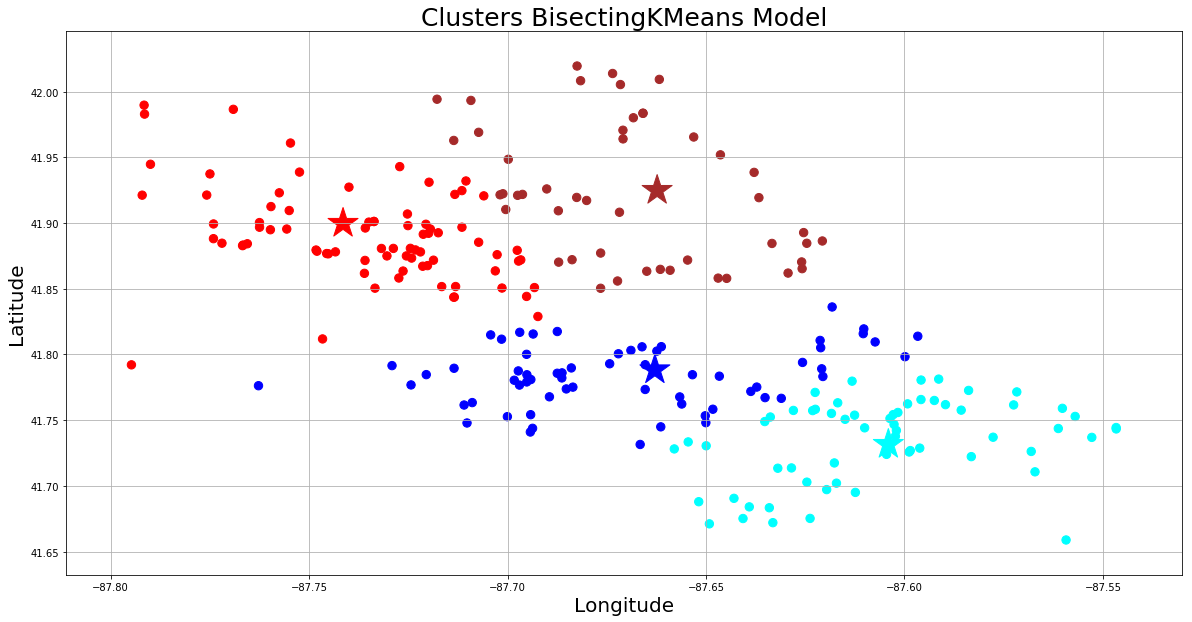

In [286]:
colors=['red','brown','blue','cyan']
assign_color=[]
x_center=[]
y_center=[]


# Append x, y coordinates of the centroids.
for r in range(len(centers_bkm)):
    x_center.append(centers_bkm[r][0])
    y_center.append(centers_bkm[r][1])

# set colors.
for r in type_cluster:
    assign_color.append(colors[r])

# Plot the data.
plt.figure(figsize=(20,10))
plt.scatter(Longitude, Latitude, c=assign_color, s=70)
plt.scatter(y_center, x_center, marker='*', c=colors, s=1000)
plt.title('Clusters BisectingKMeans Model', fontsize=25)
plt.legend(loc='lower right')
plt.xlabel('Longitude', fontsize=20)
plt.ylabel('Latitude', fontsize=20)
plt.grid()
plt.show()

## 4. Mapping the data.

In [299]:
# Set general coordinates of Chicago city
SF_COORDINATES = (41.87,  -87.62) ## Chicago Coordinates

In [312]:
# Set Map.
Map = folium.Map(location=SF_COORDINATES, zoom_start=11)

In [314]:
colors=['blue','red','green','orange']
assign_color=[]

# set colors clusters.
for r in type_cluster:
    assign_color.append(colors[r])
   
   
# Display Clusters points.
for doc in range(len(Latitude)):
    folium.Marker(location = [Latitude[doc],Longitude[doc]],
                  popup='Cluster',
                  icon=folium.Icon(color=assign_color[doc])).add_to(Map)
    


In [315]:
# Display Centroids points 'yellow Polygons'.
for loc in range(len(centers_bkm)):
    folium.RegularPolygonMarker(
            [x_center[loc],y_center[loc]],
            popup='Centroid',
            fill_color='yellow',
            number_of_sides=8,
            radius=18).add_to(Map)

In [316]:
Map

In [321]:
Map.save(outfile='C:\datosmlib\MLlib\Task1_advanced\Chicago_clusters_crime.html')